**This notebook is a scratchpad Alex used to test different models and look at the data.**

# Setup

In [653]:
%matplotlib inline

import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer

from beatpd import BEATPD, compute_challenge_error

from ml import make_roc_plot, make_error_boxplot, do_search, print_search_results, \
               print_ft_importances

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_root = '/home/alex/code/beat-pd/data/'

# Load data

In [266]:
realpd = BEATPD(data_root=data_root, studyname='REAL-PD')

Loaded demographic information for 22 participants.
Loaded labels for 782 samples.
Loaded UPDRS scores.


In [267]:
cispd = BEATPD(data_root=data_root, studyname='CIS-PD')

Loaded demographic information for 21 participants.
Loaded labels for 2476 samples.
Loaded UPDRS scores.


In [268]:
studies = [realpd, cispd]

This next part does feature extraction, which can take several minutes.  The progress bar will go through 4 times (realpd train/test, cispd train/test).

In [269]:
for study in studies:
    if study.studyname == 'CIS-PD':
        pattern = 'training_data/*.csv'
    elif study.studyname == 'REAL-PD':
        pattern = 'training_data/*_accelerometer/*.csv'
    else:
        continue
    study.load_training_set(pattern=pattern)

  0% (1 of 844) |                        | Elapsed Time: 0:00:00 ETA:   0:02:36

Extracting features...


  2% (21 of 844) |                       | Elapsed Time: 0:00:05 ETA:   0:03:55

Truncating -1 second(s) of counts to (hopefully) match up with windows.


  9% (78 of 844) |##                     | Elapsed Time: 0:00:22 ETA:   0:03:19

Truncating -1 second(s) of counts to (hopefully) match up with windows.


  9% (81 of 844) |##                     | Elapsed Time: 0:00:23 ETA:   0:03:48

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 10% (90 of 844) |##                     | Elapsed Time: 0:00:25 ETA:   0:03:45

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 21% (182 of 844) |####                  | Elapsed Time: 0:00:57 ETA:   0:04:32

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 23% (199 of 844) |#####                 | Elapsed Time: 0:01:00 ETA:   0:02:15

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 35% (297 of 844) |#######               | Elapsed Time: 0:01:29 ETA:   0:02:58/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 38% (328 of 844) |########              | Elapsed Time: 0:01:38 ETA:   0:02:14

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 64% (543 of 844) |##############        | Elapsed Time: 0:03:03 ETA:   0:02:06

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 79% (672 of 844) |#################     | Elapsed Time: 0:03:55 ETA:   0:00:51

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 83% (706 of 844) |##################    | Elapsed Time: 0:04:04 ETA:   0:00:41

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 84% (713 of 844) |##################    | Elapsed Time: 0:04:06 ETA:   0:00:39

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 90% (760 of 844) |###################   | Elapsed Time: 0:04:21 ETA:   0:00:24

Truncating -1 second(s) of counts to (hopefully) match up with windows.


100% (844 of 844) |######################| Elapsed Time: 0:04:45 Time:  0:04:45
/home/alex/code/beat-pd/beatpd.py:218: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels = pd.concat(labels, ignore_index=True, sort=False)


Created dataset containing 32459 samples from 12 participants.


  0% (1 of 217) |                        | Elapsed Time: 0:00:00 ETA:   0:00:35

Extracting features...


 23% (51 of 217) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 25% (56 of 217) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:43

Truncating -1 second(s) of counts to (hopefully) match up with windows.


100% (217 of 217) |######################| Elapsed Time: 0:01:11 Time:  0:01:11


Created dataset containing 8244 samples from 12 participants.


N/A% (0 of 1446) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Extracting features...


  0% (5 of 1446) |                       | Elapsed Time: 0:00:01 ETA:   0:05:41

Truncating -1 second(s) of counts to (hopefully) match up with windows.


  2% (34 of 1446) |                      | Elapsed Time: 0:00:07 ETA:   0:05:16

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 14% (206 of 1446) |##                   | Elapsed Time: 0:00:47 ETA:   0:04:25

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 25% (371 of 1446) |#####                | Elapsed Time: 0:01:26 ETA:   0:04:40

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 29% (431 of 1446) |######               | Elapsed Time: 0:01:39 ETA:   0:03:54

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 30% (448 of 1446) |######               | Elapsed Time: 0:01:43 ETA:   0:03:49

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 32% (474 of 1446) |######               | Elapsed Time: 0:01:49 ETA:   0:03:27

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 33% (484 of 1446) |#######              | Elapsed Time: 0:01:51 ETA:   0:03:52

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 34% (495 of 1446) |#######              | Elapsed Time: 0:01:54 ETA:   0:03:46

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 38% (559 of 1446) |########             | Elapsed Time: 0:02:08 ETA:   0:03:15

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 39% (565 of 1446) |########             | Elapsed Time: 0:02:09 ETA:   0:03:04

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 39% (566 of 1446) |########             | Elapsed Time: 0:02:10 ETA:   0:03:03

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 41% (594 of 1446) |########             | Elapsed Time: 0:02:16 ETA:   0:03:09

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 41% (598 of 1446) |########             | Elapsed Time: 0:02:17 ETA:   0:03:10

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 43% (622 of 1446) |#########            | Elapsed Time: 0:02:23 ETA:   0:03:04

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 43% (629 of 1446) |#########            | Elapsed Time: 0:02:24 ETA:   0:02:51

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 45% (664 of 1446) |#########            | Elapsed Time: 0:02:32 ETA:   0:03:05

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 51% (739 of 1446) |##########           | Elapsed Time: 0:02:50 ETA:   0:02:30

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 54% (790 of 1446) |###########          | Elapsed Time: 0:03:01 ETA:   0:02:29

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 56% (814 of 1446) |###########          | Elapsed Time: 0:03:07 ETA:   0:02:09

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 61% (894 of 1446) |############         | Elapsed Time: 0:03:25 ETA:   0:02:08

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 73% (1066 of 1446) |##############      | Elapsed Time: 0:04:06 ETA:   0:01:30

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 83% (1210 of 1446) |################    | Elapsed Time: 0:04:40 ETA:   0:00:54

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 84% (1227 of 1446) |################    | Elapsed Time: 0:04:44 ETA:   0:00:51

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 86% (1245 of 1446) |#################   | Elapsed Time: 0:04:48 ETA:   0:00:40

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 91% (1329 of 1446) |##################  | Elapsed Time: 0:05:08 ETA:   0:00:28

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 96% (1394 of 1446) |################### | Elapsed Time: 0:05:23 ETA:   0:00:11

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 96% (1402 of 1446) |################### | Elapsed Time: 0:05:24 ETA:   0:00:09

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 97% (1409 of 1446) |################### | Elapsed Time: 0:05:26 ETA:   0:00:08

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 98% (1425 of 1446) |################### | Elapsed Time: 0:05:30 ETA:   0:00:04

Truncating -1 second(s) of counts to (hopefully) match up with windows.


100% (1446 of 1446) |####################| Elapsed Time: 0:05:34 Time:  0:05:34


Created dataset containing 55879 samples from 16 participants.


N/A% (0 of 412) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Extracting features...


  6% (26 of 412) |#                      | Elapsed Time: 0:00:06 ETA:   0:01:34

Truncating -1 second(s) of counts to (hopefully) match up with windows.


  8% (33 of 412) |#                      | Elapsed Time: 0:00:07 ETA:   0:01:25

Truncating -1 second(s) of counts to (hopefully) match up with windows.


  8% (34 of 412) |#                      | Elapsed Time: 0:00:08 ETA:   0:01:24

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 10% (44 of 412) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:25

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 13% (56 of 412) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:24

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 25% (106 of 412) |#####                 | Elapsed Time: 0:00:25 ETA:   0:01:08

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 26% (110 of 412) |#####                 | Elapsed Time: 0:00:25 ETA:   0:01:01

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 38% (158 of 412) |########              | Elapsed Time: 0:00:36 ETA:   0:00:59

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 40% (165 of 412) |########              | Elapsed Time: 0:00:38 ETA:   0:00:57

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 44% (183 of 412) |#########             | Elapsed Time: 0:00:42 ETA:   0:00:53

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 45% (188 of 412) |##########            | Elapsed Time: 0:00:43 ETA:   0:00:52

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 58% (241 of 412) |############          | Elapsed Time: 0:00:55 ETA:   0:00:37

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 65% (270 of 412) |##############        | Elapsed Time: 0:01:02 ETA:   0:00:31

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 78% (325 of 412) |#################     | Elapsed Time: 0:01:15 ETA:   0:00:21

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 83% (344 of 412) |##################    | Elapsed Time: 0:01:20 ETA:   0:00:15

Truncating -1 second(s) of counts to (hopefully) match up with windows.


 97% (400 of 412) |##################### | Elapsed Time: 0:01:33 ETA:   0:00:02

Truncating -1 second(s) of counts to (hopefully) match up with windows.


100% (412 of 412) |######################| Elapsed Time: 0:01:35 Time:  0:01:35


Created dataset containing 15924 samples from 16 participants.


# Write training data to CSVs

In [272]:
# for study in studies:
#     study.save_training_data()

# Look at data

In [ ]:
realpd.demographics.describe()

In [ ]:
cispd.demographics.describe()

In [273]:
# how many subjects are available for each label?
for study in studies:
    print(study.studyname)
    for m in ['off_meds','dyskinesia','tremor']:
        print(" ", m, len(sorted((study.labels[~pd.isnull(study.labels[m])])['subject_id'].unique())))

REAL-PD
  off_meds 7
  dyskinesia 5
  tremor 6
CIS-PD
  off_meds 15
  dyskinesia 11
  tremor 13


# Challenge

This section is used to experiment with different models, not to generate the predictions for scoring.

## Subchallenge 1: Predict On/Off medication status (on_off)

### Classification

We can binarize the `on_off` field and treat it as a classification problem rather than regression.  In REAL-PD, it is already binary.  In CIS-PD, we have to threshold it.

In [725]:
on_meds_thresh = 0  # split off_meds into > or <= this value

#### CIS-PD

In [726]:
do_feature_reduction = True

In [ ]:
X_train, X_test, y_train, y_test = cispd.get_Xy_arrays(measure='off_meds', thresh=on_meds_thresh, clf=clf, do_feature_reduction=do_feature_reduction)

In [728]:
clf = RandomForestClassifier(
    # min_samples_split=2,
    min_samples_leaf=2,
    max_depth=15,
    # max_leaf_nodes=None,
    # class_weight=None,
    n_jobs=8,
)

In [737]:
cispd.train(measure='off_meds', clf=clf, thresh=on_meds_thresh, do_feature_reduction=do_feature_reduction)

Trained clf for classification of off_meds.


In [738]:
cispd.validate(measure='off_meds', clf=clf, thresh=on_meds_thresh, do_feature_reduction=do_feature_reduction)

==== Results on training set: ====
Score (mean accuracy):  0.8226883086669411
AUC:  0.9286888870237248
==== Results on test set: ====
Score (mean accuracy):  0.7326048731474504
AUC:  0.8092903918551437


(0.8226883086669411, 0.7326048731474504)

In [739]:
print_ft_importances(clf, X_test, num=10)

UPDRS_4.1: 0.0853
UPDRS_3_PCA_9: 0.0659
UPDRS_3_PCA_7: 0.0498
UPDRS_3_PCA_2: 0.0475
vm_mean: 0.0469
UPDRS_3_PCA_4: 0.0454
UPDRS_3_PCA_6: 0.0443
UPDRS_3_PCA_8: 0.0337
UPDRS_4.4: 0.0308
corr_yz: 0.0306


In [740]:
#np.sum(y_test), len(y_test)  # number of off med samples vs. total number of samples

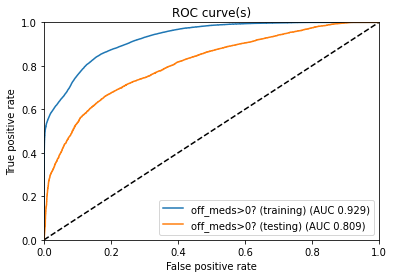

In [741]:
make_roc_plot(clf, X_test, y_test, 'off_meds>0?', X_train=X_train, y_train=y_train)

In [742]:
# only predicting 0/1, so this shouldn't work very well:
contest_predictions = cispd.predict_for_contest('off_meds', clf, do_feature_reduction=do_feature_reduction)

Challenge error for off_meds: 1.8489 (using up to 412 rows)


#### REAL-PD

In [331]:
do_feature_reduction = True

In [332]:
clf = RandomForestClassifier(
    # min_samples_split=2,
    min_samples_leaf=2,
    max_depth=15,
    # max_leaf_nodes=None,
    # class_weight=None,
    n_jobs=8,
)

In [333]:
realpd.train(measure='off_meds', clf=clf, thresh=on_meds_thresh, do_feature_reduction=do_feature_reduction)

Running feature selection...
Will keep 50 features.
Trained clf for classification of off_meds.


In [334]:
realpd.validate(measure='off_meds', clf=clf, thresh=on_meds_thresh, do_feature_reduction=do_feature_reduction)

==== Results on training set: ====
Score (mean accuracy):  0.9324378446655781
AUC:  0.9856332848493524
==== Results on test set: ====
Score (mean accuracy):  0.8369723435225619
AUC:  0.8548546982535088


In [335]:
X_train, X_test, y_train, y_test = realpd.get_Xy_arrays(measure='off_meds', thresh=on_meds_thresh, clf=clf, 
                                                        do_feature_reduction=do_feature_reduction)

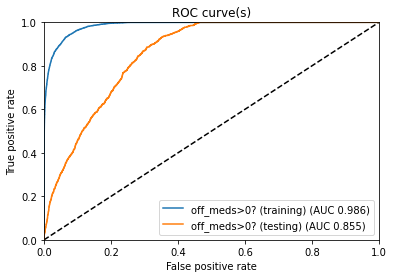

In [336]:
make_roc_plot(clf, X_test, y_test, 'off_meds>0?', X_train=X_train, y_train=y_train)

In [337]:
contest_predictions = realpd.predict_for_contest('off_meds', clf, do_feature_reduction=do_feature_reduction)

Error for off_meds: 0.031 (using 112 rows)


/home/alex/code/beat-pd/beatpd.py:373: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(y_pred) != len(y_test):


### Regression

#### CIS-PD

In [630]:
do_feature_reduction = False

In [631]:
X_train, X_test, y_train, y_test = cispd.get_Xy_arrays(
    measure = 'off_meds',
    clf = RandomForestRegressor(),
    do_feature_reduction = do_feature_reduction
)
     
scorer = make_scorer(
    compute_challenge_error,
    greater_is_better = False,
    pt_ids = cispd.training_data['subject_id']  #.loc[~pd.isnull(y_test), 'subject_id']
)

In [572]:
clf = RandomForestRegressor(
    max_depth=15,
    n_jobs=8,
)

In [650]:
search_params = {
    #'n_estimators': [50,100,200],
    'max_depth': [5,8,10,12,16],
    'min_samples_split': [4,8,None],
    'min_samples_leaf': [2,3,5,10],
    #'max_features': np.arange(2,len(X_train.columns),5),  # TODO: 10,20,30
    #'max_leaf_nodes': [20,50,100],
    'max_leaf_nodes': [20,50,100,200,None],
}

best_cis_med_rf_reg = do_search(
    RandomForestRegressor(),
    search_params,
    X_train,
    y_train,
    random=True,
    n_iter=200,
    n_jobs=8,
    scorer = {'contest_err': scorer},
    test = 'contest_err'
)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   36.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 13.4min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed: 24.7min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 38.0min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed: 48.3min finished


Search results (top 50):
     rank_test_contest_err  mean_test_contest_err  std_test_contest_err param_min_samples_split param_min_samples_leaf param_max_leaf_nodes param_max_depth
192                      1                 -1.790                 0.714                       8                      5                   20              16
97                       2                 -1.790                 0.713                       8                     10                   20              16
24                       3                 -1.791                 0.720                       8                      2                   20              12
196                      4                 -1.792                 0.717                       4                      5                   20              12
111                      5                 -1.792                 0.715                       8                      5                   20              12
18                       6             

In [641]:
clf = best_cis_med_rf_reg

In [348]:
# best_cis_rf_meds_reg_params = {
#     # ...
# }  # TODO: seach using R^2 as metric

# best_cis_rf_meds_reg_params = {
#     'min_samples_split': 4,
#     'min_samples_leaf': 2,
#     'max_leaf_nodes': 50,
#     'max_features': 32,
#     'max_depth': 16
# }  # for -mean_abs_err (random search)

# best_cis_rf_meds_reg_params = {
#     'min_samples_split': 4,
#     'min_samples_leaf': 5,
#     'max_leaf_nodes': 50,
#     'max_features': 12,
#     'max_depth': 4,
# }  # for -mean_abs_err (full search)

best_cis_rf_meds_reg_params = {
    'min_samples_leaf': 3,  # 3-5
    #'min_samples_split': 8,  # 8?
    #'max_leaf_nodes': 100,  # 40-50?
    'max_depth': 12,  # 8-16
}  # manual


In [349]:
clf = RandomForestRegressor(n_jobs=8, **best_cis_rf_meds_reg_params)

In [642]:
cispd.train(measure='off_meds', clf=clf, do_feature_reduction=do_feature_reduction)
cispd.validate(measure='off_meds', clf=clf, do_feature_reduction=do_feature_reduction)

Trained clf for regression of off_meds.
==== Results on training set: ====
Score (R^2):  0.22239559006697684
==== Results on test set: ====
Score (R^2):  0.18917562194220228


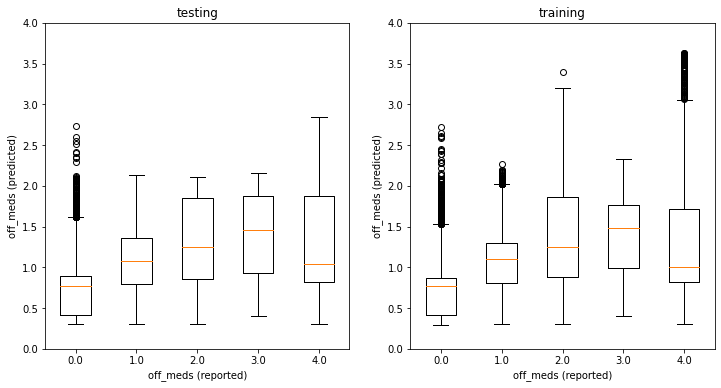

In [643]:
predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train)

make_error_boxplot(
    predictions,
    y_test,
    'off_meds',
    y_predicted_train = train_predictions,
    y_train = y_train,
    ylims=(0,4)

)

In [644]:
print_ft_importances(clf, X_test, num=10)  # UPDRS 4.1 = percent of day with dyskinesias

UPDRS_3_PCA_7 0.35739245087285704
UPDRS_3_PCA_2 0.09873588889081088
vm_mean 0.07720566289834521
UPDRS_3_PCA_9 0.052830822383048634
UPDRS_4.6 0.048734101629539686
UPDRS_3_PCA_6 0.04852997054872038
corr_yz 0.03585160468729326
ps_entropy 0.033125002959405105
cpm_mean 0.024962428097655396
UPDRS_3_PCA_4 0.024905117815978192


In [648]:
contest_predictions = cispd.predict_for_contest('off_meds', clf, do_feature_reduction=do_feature_reduction)

Error for off_meds: 1.27779 (using up to 412 rows)


#### REAL-PD

In [580]:
do_feature_reduction = False

In [581]:
X_train, X_test, y_train, y_test = realpd.get_Xy_arrays(
    measure = 'off_meds', 
    clf = RandomForestRegressor(), 
    do_feature_reduction = do_feature_reduction
)

In [95]:
random_search_params = {
    #'n_estimators': [50,100,200],
    'max_depth': [4,8,12,16],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [2,5,10],
    'max_features': [10,20,30],  # np.arange(2,len(X_train.columns),5), 
    'max_leaf_nodes': [20,40,60,80,100,None],
    #'min_weight_fraction_leaf': [0.0],
    #'min_impurity_decrease': [0.0],
    #'bootstrap': [True],
}

best_rf_reg_realpd_meds = do_search(
    RandomForestRegressor(),
    random_search_params,
    X_train,
    y_train,
    random=False,
    #n_iter=2000,
    n_jobs=8,
)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   35.8s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 16.6min
[Parallel(n_jobs=8)]: Done 3240 out of 3240 | elapsed: 17.2min finished


Search results (top 50):
     rank_test_R^2  mean_test_R^2  std_test_R^2 param_max_depth param_max_features param_max_leaf_nodes param_min_samples_leaf param_min_samples_split
2                1         -0.043         0.039               4                 10                   20                      2                       8
176              2         -0.045         0.041               8                 10                   40                      5                       8
32               3         -0.046         0.036               4                 10                   80                      5                       8
27               4         -0.046         0.040               4                 10                   80                      2                       2
163              5         -0.046         0.038               8                 10                   20                      2                       4
492              6         -0.047         0.041              16      

In [582]:
clf = RandomForestRegressor(
    max_depth=15,
    n_jobs=8,
)


In [388]:
best_realpd_reg_params_meds = {
    'min_samples_split': 8,
    'min_samples_leaf': 2,
    'max_leaf_nodes': 50,
    'max_features': 10,
    'max_depth': 12
}

clf = RandomForestRegressor(
    n_jobs=8,
    **best_realpd_reg_params_meds,
)

In [583]:
realpd.train(measure='off_meds', clf=clf, do_feature_reduction=do_feature_reduction)

Trained clf for regression of off_meds.


In [584]:
realpd.validate(measure='off_meds', clf=clf, do_feature_reduction=do_feature_reduction)

==== Results on training set: ====
Score (R^2):  0.7401635970286772
==== Results on test set: ====
Score (R^2):  0.053805764534449074


In [585]:
print_ft_importances(clf, X_test, num=10)  # UPDRS 4.1 = percent of day with dyskinesias

vm_mean 0.16932804521607717
corr_xy 0.07965966214765782
cpm_mean 0.0791668299830816
corr_yz 0.07764393039464272
corr_xz 0.07152359001119142
ps_entropy 0.05428572547911801
UPDRS_PartI_Total 0.04280491802164195
UPDRS_3_PCA_3 0.04159684903544268
vm_std 0.040698512517601405
p1_fraction 0.039571421095355414


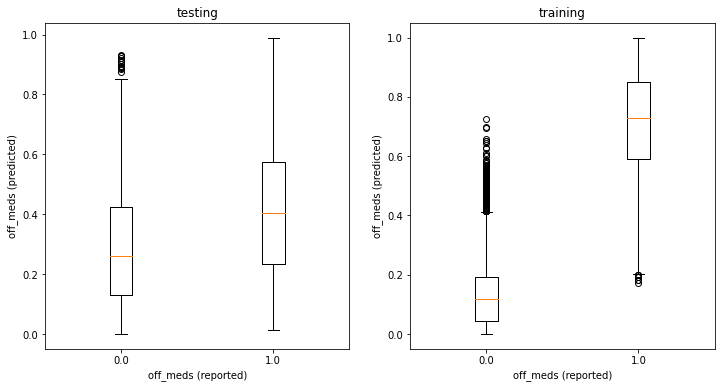

In [586]:
predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train)

make_error_boxplot(
    predictions,
    y_test,
    'off_meds',
    y_predicted_train = train_predictions,
    y_train = y_train
)

In [587]:
contest_predictions = realpd.predict_for_contest('off_meds', clf, do_feature_reduction=do_feature_reduction)

Error for off_meds: 0.18839 (using up to 200 rows)


## Subchallenge 2: Predict Dyskinesia severity (dyskinesia)

### CIS-PD

In [412]:
do_feature_reduction = True

In [413]:
X_train, X_test, y_train, y_test = cispd.get_Xy_arrays(measure='dyskinesia', clf=RandomForestRegressor(), 
                                                       do_feature_reduction=do_feature_reduction)

Running feature selection...
Will keep 20 features.


In [414]:
clf = RandomForestRegressor(
    max_depth=15,
    n_jobs=8,
)

# ==== Results on training set: ====
# Score (R^2):  0.7897727239364919
# ==== Results on test set: ====
# Score (R^2):  0.563356456674908

In [133]:
search_params = {
    #'n_estimators': [50,100,200],
    'max_depth': [5,10,15,20],
    'min_samples_split': [4,6,8],
    'min_samples_leaf': [2,5,10],
    'max_features': [10,15,20],  # np.arange(2,len(X_train.columns),5), 
    'max_leaf_nodes': [20,50,100,200],
    #'min_weight_fraction_leaf': [0.0],
    #'min_impurity_decrease': [0.0],
    #'bootstrap': [True],
}

best_rf_reg_cispd_dys = do_search(
    RandomForestRegressor(),
    search_params,
    X_train,
    y_train,
    random=False,
    #n_iter=1000,
    n_jobs=8,
    test='R^2'
)

# best_params = {
#     'n_estimators': 50,
#     'min_samples_split': 4,
#     'max_leaf_nodes': 50,
#     'max_features': 20,
#     'max_depth': 8
# }
# ==== Results on training set: ====
# Score (R^2):  0.5738622200355245
# ==== Results on test set: ====
# Score (R^2):  0.5113633772178865


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   33.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  8.4min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed: 11.8min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed: 15.6min
[Parallel(n_jobs=8)]: Done 2160 out of 2160 | elapsed: 17.1min finished


Search results (top 50):
     rank_test_R^2  mean_test_R^2  std_test_R^2 param_max_depth param_max_features param_max_leaf_nodes param_min_samples_leaf param_min_samples_split
81               1          0.169         0.161               5                 20                   50                      2                       4
297              2          0.168         0.162              15                 20                   50                      2                       4
415              3          0.150         0.166              20                 20                  100                      2                       6
82               4          0.150         0.183               5                 20                   50                      2                       6
99               5          0.147         0.166               5                 20                  200                      2                       4
410              6          0.146         0.179              20      

In [420]:
best_params_manual = {
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    #'max_leaf_nodes': 30,
    'max_features': 20,
    'max_depth': 12
}

clf = RandomForestRegressor(n_jobs=8, **best_params_manual)

In [421]:
cispd.train(measure='dyskinesia', clf=clf, do_feature_reduction=do_feature_reduction)

Trained clf for regression of dyskinesia.


In [422]:
cispd.validate(measure='dyskinesia', clf=clf, do_feature_reduction=do_feature_reduction)

==== Results on training set: ====
Score (R^2):  0.7154220701878463
==== Results on test set: ====
Score (R^2):  0.48493734111402315


In [423]:
print_ft_importances(clf, X_test)

UPDRS_4.1 0.40636032573374775
UPDRS_4.4 0.11261642151416808
UPDRS_3_PCA_3 0.05581318586744923
vm_mean 0.045112103208244186
UPDRS_3_PCA_2 0.04154562180823885
UPDRS_3_PCA_0 0.04106074176580497
subject_1048 0.03396649481289915
age 0.03207951817538979
UPDRS_3_PCA_5 0.029482754492651652
corr_yz 0.024375557187898814


When we limit overfitting (e.g. with `max_leaf_nodes`, `min_samples_leaf`), it doesn't really even use the sensor data!  It also singles out pt 1048.

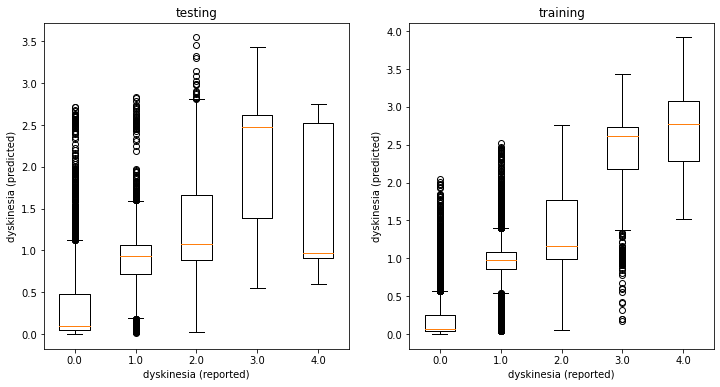

In [424]:
predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train)

make_error_boxplot(
    y_predicted_test = predictions,
    y_test = y_test,
    featurename = 'dyskinesia',
    y_predicted_train = train_predictions,
    y_train = y_train
)

In [425]:
contest_predictions = cispd.predict_for_contest('dyskinesia', clf, do_feature_reduction=do_feature_reduction)

Error for dyskinesia: 0.045 (using 273 rows)


/home/alex/code/beat-pd/beatpd.py:373: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_test = y_test[~nans]


### REAL-PD

In [448]:
do_feature_reduction = True

In [449]:
X_train, X_test, y_train, y_test = realpd.get_Xy_arrays(measure='dyskinesia', clf=RandomForestRegressor(),
                                                        do_feature_reduction=do_feature_reduction)

In [442]:
clf = RandomForestRegressor(
    max_depth=15,
    n_jobs=8,
    #min_weight_fraction_leaf=0.0,
    #min_impurity_decrease=0.0,
    #max_leaf_nodes=None,
    #max_features='auto',
    #min_impurity_split=None,
    #random_state=None,
)

# ==== Results on training set: ====
# Score (R^2):  0.8468356521833046
# ==== Results on test set: ====
# Score (R^2):  0.16455057464068223


In [162]:
search_params = {
    'max_depth': [5,10,15,20],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [2,5,10],
    'max_features': [10,15,20],  # np.arange(2,len(X_train.columns),5), 
    'max_leaf_nodes': [20,50,100,None],
    #'min_weight_fraction_leaf': [0.0],
    #'min_impurity_decrease': [0.0],
    #'bootstrap': [True],
}

best_rf_reg_realpd_dys = do_search(
    RandomForestRegressor(),
    search_params,
    X_train,
    y_train,
    random=False,
    #n_iter=1000,
    n_jobs=8,
    test='R^2'
)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   34.5s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:  5.8min
[Parallel(n_jobs=8)]: Done 2160 out of 2160 | elapsed:  6.4min finished


Search results (top 50):
     rank_test_R^2  mean_test_R^2  std_test_R^2 param_max_depth param_max_features param_max_leaf_nodes param_min_samples_leaf param_min_samples_split
115              1      4.252e-03         0.292              10                 10                   20                     10                       4
114              2     -2.432e-04         0.295              10                 10                   20                     10                       2
31               3     -1.698e-03         0.280               5                 10                 None                      5                       4
254              4     -1.831e-03         0.303              15                 15                   20                      2                       8
404              5     -3.642e-03         0.304              20                 20                   20                     10                       8
111              6     -3.720e-03         0.301              10      

In [450]:
params = {
    'min_samples_split': 4,
    'min_samples_leaf': 5,
    'max_leaf_nodes': 40,
    'max_features': 10,
    'max_depth': 10
}

clf = RandomForestRegressor(n_jobs=8, **params)

In [451]:
realpd.train(measure='dyskinesia', clf=clf, do_feature_reduction=do_feature_reduction)

Trained clf for regression of dyskinesia.


In [452]:
realpd.validate(measure='dyskinesia', clf=clf, do_feature_reduction=do_feature_reduction)

==== Results on training set: ====
Score (R^2):  0.4908568318125459
==== Results on test set: ====
Score (R^2):  0.26926906210061696


In [453]:
print_ft_importances(clf, X_test)

UPDRS_3_PCA_3 0.42705561503556716
UPDRS_3_PCA_1 0.19427547763318956
vm_mean 0.09678231260131628
UPDRS_3_PCA_0 0.05283319810573509
cpm_mean 0.049688181317778496
UPDRS_4.5 0.042246327921597625
vm_std 0.023931167997380945
total_power 0.021015798652662922
f625_power 0.012910790687340058
corr_xy 0.011676092741503564


Again, limiting overfitting seems to virtually eliminate sensor features.

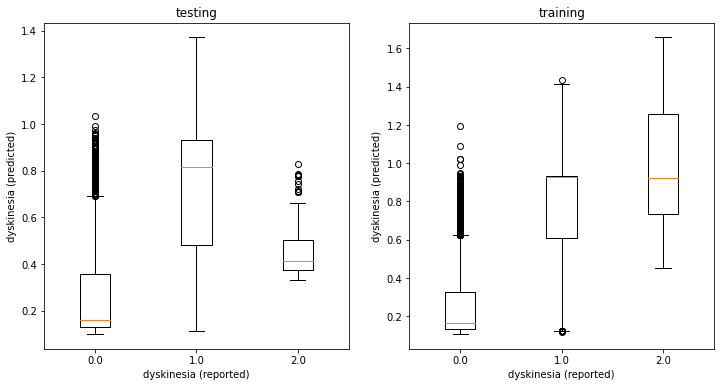

In [454]:
predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train)

make_error_boxplot(
    y_predicted_test = predictions,
    y_test = y_test,
    featurename = 'dyskinesia',
    y_predicted_train = train_predictions,
    y_train = y_train
)

In [455]:
contest_predictions = realpd.predict_for_contest('dyskinesia', clf, do_feature_reduction=do_feature_reduction)

Error for dyskinesia: 0.04437 (using 83 rows)


/home/alex/code/beat-pd/beatpd.py:373: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_test = y_test[~nans]


## Subchallenge 3: Predict Tremor severity (tremor)

### CIS

In [470]:
do_feature_reduction = True

In [471]:
X_train, X_test, y_train, y_test = cispd.get_Xy_arrays(measure='tremor', clf=RandomForestRegressor(),
                                                       do_feature_reduction=do_feature_reduction)

Running feature selection...
Will keep 51 features.


In [484]:
clf = RandomForestRegressor(
    max_depth=15,
    n_jobs=8,
)
# ==== Results on training set: ====
# Score (R^2):  0.7312419790572671
# ==== Results on test set: ====
# Score (R^2):  0.5060285790569299


In [216]:
search_params = {
    'max_depth': [5,10,15],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [2,5,10],
    'max_features': [8,10,12,16,20],  # np.arange(2,len(X_train.columns),5), 
    'max_leaf_nodes': [20,50,100,None],
    #'bootstrap': [True],
}

best_rf_reg_cispd_trem = do_search(
    RandomForestRegressor(),
    search_params,
    X_train,
    y_train,
    random=False,
    #n_iter=1000,
    n_jobs=8,
    test='R^2'
)


Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   36.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  8.4min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed: 12.3min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed: 17.4min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed: 23.4min
[Parallel(n_jobs=8)]: Done 2700 out of 2700 | elapsed: 25.5min finished


Search results (top 50):
     rank_test_R^2  mean_test_R^2  std_test_R^2 param_max_depth param_max_features param_max_leaf_nodes param_min_samples_leaf param_min_samples_split
14               1      7.920e-02         0.437               5                  8                   50                      5                       8
1                2      6.316e-02         0.436               5                  8                   20                      2                       4
197              3      4.712e-02         0.435              10                  8                   50                     10                       8
54               4      3.821e-02         0.471               5                 10                  100                      2                       2
261              5      3.780e-02         0.492              10                 12                   50                      2                       2
112              6      3.747e-02         0.480               5      

In [478]:
# params = {
#     'min_samples_split': 4,
#     'min_samples_leaf': 3,
#     'max_features': 12,
#     'max_depth': 15
#     #'max_leaf_nodes': 100,
# }
# # ==== Results on training set: ====
# # Score (R^2):  0.6747840493930115
# # ==== Results on test set: ====
# # Score (R^2):  0.5656523573609529

params = {
    'min_samples_split': 4,
    'min_samples_leaf': 4,
    'max_features': 10,
    'max_depth': 15,
    'max_leaf_nodes': 100,
}

clf = RandomForestRegressor(n_jobs=8, **params)

In [485]:
cispd.train(measure='tremor', clf=clf, do_feature_reduction=do_feature_reduction)

Trained clf for regression of tremor.


In [486]:
cispd.validate(measure='tremor', clf=clf, do_feature_reduction=do_feature_reduction)

==== Results on training set: ====
Score (R^2):  0.763303152201585
==== Results on test set: ====
Score (R^2):  0.5011370037279135


In [487]:
print_ft_importances(clf, X_test)

UPDRS_3_PCA_8 0.32371285494145996
UPDRS_3_PCA_7 0.06254960573932189
vm_mean 0.05265425128942227
UPDRS_4.1 0.049159159166393886
UPDRS_3_PCA_4 0.04840390393157189
subject_1048 0.04295122104267924
age 0.036404135973333474
UPDRS_3_PCA_2 0.0357384060395737
UPDRS_3_PCA_5 0.030546799233289405
corr_xy 0.025040749946564196


As always, less overfitting = less sensor data used.  And pt 1048 was singled out again.

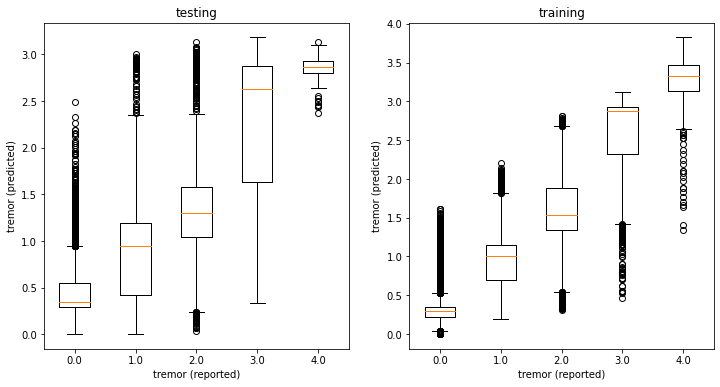

In [488]:
predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train)

make_error_boxplot(
    y_predicted_test = predictions,
    y_test = y_test,
    featurename = 'tremor',
    y_predicted_train = train_predictions,
    y_train = y_train
)

In [489]:
contest_predictions = cispd.predict_for_contest('tremor', clf, do_feature_reduction=do_feature_reduction)

Error for tremor: 0.03202 (using 331 rows)


/home/alex/code/beat-pd/beatpd.py:373: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_test = y_test[~nans]


### REAL

In [504]:
do_feature_reduction = True

In [505]:
X_train, X_test, y_train, y_test = realpd.get_Xy_arrays(measure='tremor', clf=RandomForestRegressor(), 
                                                        do_feature_reduction=do_feature_reduction)

Running feature selection...
Will keep 24 features.


In [506]:
clf = RandomForestRegressor(
    max_depth = 15,
    n_jobs = 8,
)
# ==== Results on training set: ====
# Score (R^2):  0.8817056077520928
# ==== Results on test set: ====
# Score (R^2):  0.5664620224481605

In [257]:
search_params = {
    'max_depth': [5,10,15,20],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [2,5,10],
    'max_features': [5,10,15,20],  # np.arange(2,len(X_train.columns),5), 
    'max_leaf_nodes': [20,50,100,None],
    #'bootstrap': [True],
}

best_rf_reg_realpd_trem = do_search(
    RandomForestRegressor(),
    search_params,
    X_train,
    y_train,
    random=False,
    #n_iter=1000,
    n_jobs=8,
    test='R^2'
)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   29.9s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  8.3min
[Parallel(n_jobs=8)]: Done 2880 out of 2880 | elapsed: 10.0min finished


Search results (top 50):
     rank_test_R^2  mean_test_R^2  std_test_R^2 param_max_depth param_max_features param_max_leaf_nodes param_min_samples_leaf param_min_samples_split
152              1         -0.206         0.271              10                  5                   20                     10                       8
39               2         -0.208         0.243               5                 10                   20                      5                       2
6                3         -0.215         0.249               5                  5                   20                     10                       2
185              4         -0.217         0.246              10                 10                   20                      5                       8
304              5         -0.217         0.240              15                  5                   50                     10                       4
80               6         -0.220         0.255               5      

In [512]:
params = {
    'min_samples_split': 6,
    'min_samples_leaf': 5,
    'max_features': 10,
    'max_depth': 10,
    'max_leaf_nodes': 20,
}
# ==== Results on training set: ====
# Score (R^2):  0.673480071632335
# ==== Results on test set: ====
# Score (R^2):  0.5881735929736678

clf = RandomForestRegressor(n_jobs=8, **params)

In [514]:
realpd.train(measure='tremor', clf=clf, do_feature_reduction=do_feature_reduction)
realpd.validate(measure='tremor', clf=clf, do_feature_reduction=do_feature_reduction)

==== Results on training set: ====
Score (R^2):  0.6928502543634003
==== Results on test set: ====
Score (R^2):  0.5844979586604273


In [515]:
print_ft_importances(clf, X_test)

UPDRS_PartI_Total 0.5248762700706475
UPDRS_3_PCA_1 0.19588628832772448
UPDRS_3_PCA_0 0.15345013268922364
UPDRS_4.5 0.04716507828781055
vm_mean 0.01568072355473683
cpm_mean 0.014582375475915864
UPDRS_4.3 0.012909741970076504
f2_Hz 0.005550711586838769
subject_hbv054 0.004649522291731668
f2_power 0.003980456946478255


Reducing complexity prioritizes UPDRS...

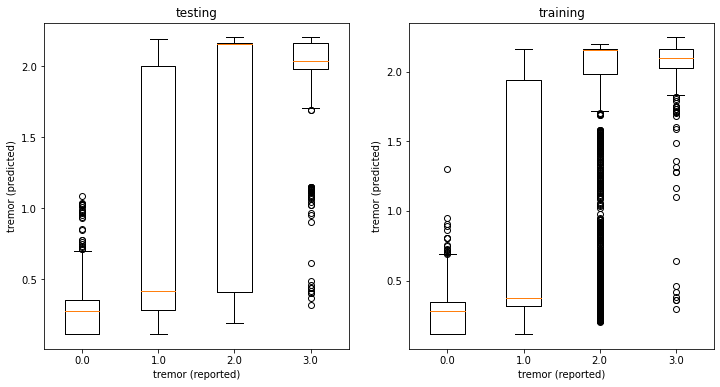

In [548]:
predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train)

make_error_boxplot(
    y_predicted_test = predictions,
    y_test = y_test,
    featurename = 'tremor',
    y_predicted_train = train_predictions,
    y_train = y_train
)

In [549]:
contest_predictions = realpd.predict_for_contest('tremor', clf, do_feature_reduction=do_feature_reduction)

Error for tremor: 0.21048 (using 200 rows)


# Generate everything

In [678]:
logfile = '/tmp/beatpd.log'

In [679]:
def debug(s, logfile='/tmp/beatpd.log'):
    print(s)
    with open(logfile,'a') as f:
        f.write("[%s] %s\n" % (dt.datetime.now(), s))

In [680]:
# for study in studies:
#     for test in ['off_meds','dyskinesia','tremor']:
#         print(study.studyname, test)
#         #print(" ", study.top_features[test]['regression'])
#         X_train, X_test, y_train, y_test = study.get_Xy_arrays(
#                 measure = test,
#                 clf = RandomForestRegressor(),
#                 do_feature_reduction = False
#         )
#         print("  %d features selected from %d" % (len(study.top_features[test]['regression']), len(X_train.columns)))
#         #print(X_train.shape)

working on off_meds
working on REAL-PD
Feature reduction: False
Will use naive classifier.
Training naive classifier.
Trained clf for regression of off_meds.
==== Results on training set: ====
Score (R^2):  0.7384417698984178
==== Results on test set: ====
Score (R^2):  0.05783206292299625
Scores for naive classifier (R^2): 0.0578, 0.7384 (test, train)
Feature importances:
working on CIS-PD
Feature reduction: False
Will use naive classifier.
Training naive classifier.
Trained clf for regression of off_meds.
==== Results on training set: ====
Score (R^2):  0.5080395663751258
==== Results on test set: ====
Score (R^2):  0.18710758563688734
Scores for naive classifier (R^2): 0.1871, 0.5080 (test, train)
Feature importances:
working on dyskinesia
working on REAL-PD
Feature reduction: False
Will use naive classifier.
Training naive classifier.
Trained clf for regression of dyskinesia.
==== Results on training set: ====
Score (R^2):  0.8596097989007951
==== Results on test set: ====
Score (R

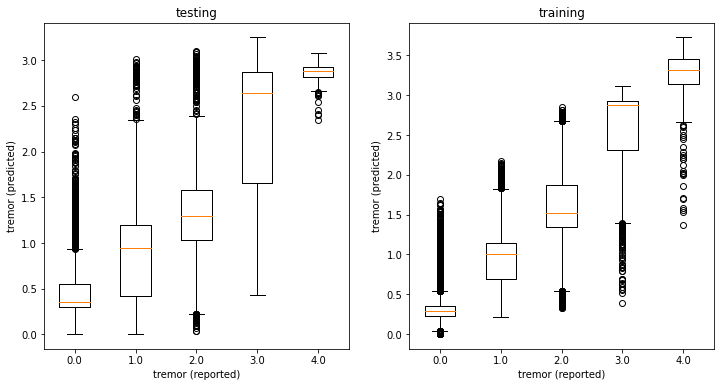

In [724]:
for subchallenge in ['off_meds','dyskinesia','tremor']:
    debug("working on %s" % subchallenge)
    for study in studies:
        debug("working on %s" % study.studyname)
        scorer = make_scorer(
            compute_challenge_error,
            greater_is_better = False,
            pt_ids = study.training_data['subject_id']
        )
        for do_feature_reduction in [False, True]:
            ft_red_str = 'feature_reduction_%s' % str(do_feature_reduction)
            debug("Feature reduction: %s" % str(do_feature_reduction))
            X_train, X_test, y_train, y_test = study.get_Xy_arrays(
                measure = subchallenge,
                clf = RandomForestRegressor(),
                do_feature_reduction = do_feature_reduction
            )
            for clf_type in ['naive','optimal']:
                if clf_type == 'naive':
                    debug("Will use naive classifier.")
                    clf = RandomForestRegressor(
                        max_depth=15,
                        n_jobs=8,
                    )
                else:
                    search_params = {
                        'max_depth': [5,8,10,12,15,20],
                        #'min_samples_split': [2,4,8],
                        'min_samples_leaf': [2,4,8,16],
                        'max_features': [0.2, 0.4, 0.6, 0.8, 1.0, 'auto'],
                        'max_leaf_nodes': [20,50,100,200,None],
                    }
                    test = '-mean_sq_err'  # 'contest_err'
                    debug("Doing hyperparameter search for best classifier.  Refitting on %s." % test)
                    clf = do_search(
                        RandomForestRegressor(n_jobs=2),
                        search_params,
                        X_train,
                        y_train,
                        random = False,
                        #n_iter = 200,
                        n_jobs = 8,
                        scorer = {'contest_err': scorer},
                        test = test,
                        logfile = logfile,
                        #show_summary = False,
                    )
                debug("Training %s classifier." % clf_type)
                study.train(
                    measure = subchallenge,
                    clf = clf,
                    do_feature_reduction = do_feature_reduction
                )
                train_score, val_score = study.validate(
                    measure = subchallenge,
                    clf = clf,
                    do_feature_reduction = do_feature_reduction
                )
                debug("Scores for %s classifier (R^2): %0.4f, %0.4f (test, train)" % \
                     (clf_type, val_score, train_score))
                contest_predictions = study.predict_for_contest(
                    subchallenge,
                    clf,
                    do_feature_reduction = do_feature_reduction,
                    logfile = logfile
                )
                debug("Feature importances:")
                print_ft_importances(clf, X_test, logfile=logfile)
                predictions = clf.predict(X_test)
                train_predictions = clf.predict(X_train)
                plt.close('all')
                make_error_boxplot(
                    y_predicted_test = predictions,
                    y_test = y_test,
                    featurename = subchallenge,
                    y_predicted_train = train_predictions,
                    y_train = y_train,
                    filename = './plots/%s_%s_%s_%s.png' % \
                               (subchallenge, study.studyname, ft_red_str, clf_type),
                )
debug("Done.\n\n")

# Testing

# Notes